## TC 5033
### Word Embeddings

<br>

#### Activity 3b: Text Classification using RNNs and AG_NEWS dataset in PyTorch
<br>


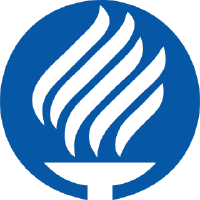

## TEAM 33
| ID          | Name                          |
|-------------|-------------------------------|
| A01794956   | Luis Oporto                   |
| A00915255   | Ernesto Zapata                |
| A01065270   | José Manuel Romo Peredo       |
| A01795483   | Nicolás Araque                |
| A01794892   | Eduardo Rodriguez Ramirez     |

- Objective:
    - Understand the basics of Recurrent Neural Networks (RNNs) and their application in text classification.
    - Learn how to handle a real-world text dataset, AG_NEWS, in PyTorch.
    - Gain hands-on experience in defining, training, and evaluating a text classification model in PyTorch.
    
<br>

- Instructions:
    - Data Preparation: Starter code will be provided that loads the AG_NEWS dataset and prepares it for training. Do not modify this part. However, you should be sure to understand it, and comment it, the use of markdown cells is suggested.

    - Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

    - Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

    - Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

    - Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

    - Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

    - Submission: Submit your completed Jupyter Notebook. Make sure to include a markdown cell at the beginning of the notebook that lists the names of all team members. Teams should consist of 3 to 4 members.
    
<br>

- Evaluation Criteria:

    - Correct setup of all the required libraries and modules (10%)
    - Code Quality (30%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity. Comments should be given for all the provided code, this will help you understand its functionality.
    
   - Functionality (60%):
        - All the functions should execute without errors and provide the expected outputs.
        - RNN model class (20%)
        - Accuracy fucntion (10%)
        - Training function (10%)
        - Sampling function (10%)
        - Confucion matrix (10%)

        - The model should achieve at least an 80% accuracy on the AG_NEWS test set for full marks in this criterion.


Dataset

https://pytorch.org/text/stable/datasets.html#text-classification

https://paperswithcode.com/dataset/ag-news


#### Install libraries (if needed)

You may need to install the following libraries to ensure version compatibility. After installing them, please Restart the Session (Runtime -> Restart Session)

In [1]:
#!pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 torchtext==0.15.2

In [2]:
# !pip install scipy==1.9.3
# !pip install scikit-plot
#you may receive a message of restarting session, this is OK

In [3]:
# !pip install portalocker
#please restar session after this intallation. After restarting go straight to importing the libraries

## Import libraries

In [ ]:
# The following libraries are required for running the given code
# Please feel free to add any libraries you consider adecuate to complete the assingment.
import numpy as np
#PyTorch libraries
import torch
from torchtext.datasets import AG_NEWS
# Dataloader library
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
# neural layers
from torch import nn
from torch.nn import functional as F

# These libraries are suggested to plot confusion matrix
# you may use others
import scikitplot as skplt
import gc
from matplotlib import pyplot as plt
import random

In [5]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Get the train and the test datasets and dataloaders

Classes:

* 1 - World

* 2 - Sports

* 3 - Business

* 4 - Sci/Tech

We will convert them to:

* 0 - World

* 1 - Sports

* 2 - Business

* 3 - Sci/Tech

In [6]:
train_dataset, test_dataset = AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [7]:
# Get the tokeniser
# tokeniser object
tokeniser = get_tokenizer('basic_english')

def yield_tokens(data):
    for _, text in data:
        yield tokeniser(text)

In [8]:
# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])
#set unknown token at position 0
vocab.set_default_index(vocab["<unk>"])

In [9]:
#test tokens
tokens = tokeniser('Welcome to TC5033')
print(tokens, vocab(tokens))

['welcome', 'to', 'tc5033'] [3314, 4, 0]


In [10]:
NUM_TRAIN = int(len(train_dataset)*0.9)
NUM_VAL = len(train_dataset) - NUM_TRAIN

In [11]:
train_dataset, val_dataset = random_split(train_dataset, [NUM_TRAIN, NUM_VAL])

In [12]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

108000 12000 7600


In [13]:
# function passed to the DataLoader to process a batch of data as indicated
def collate_batch(batch):
    # Get label and text
    y, x = list(zip(*batch))

    # Create list with indices from tokeniser
    x = [vocab(tokeniser(text)) for text in x]
    x = [t + ([0]*(max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]

    # Prepare the labels, by subtracting 1 to get them in the range 0-3
    return torch.tensor(x, dtype=torch.int32), torch.tensor(y, dtype=torch.int32) - 1

In [14]:
labels =  ["World", "Sports", "Business", "Sci/Tech"]
max_tokens = 50
BATCH_SIZE = 256

In [15]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)

### Let us build our RNN model

In [16]:
EMBEDDING_SIZE = 300
NEURONS = 256
LAYERS = 2
NUM_CLASSES = 4

In [ ]:
# RNN Model Class
class RNN_Model_1(nn.Module):

    def __init__(self, embed_size, hidden, layers, num_classes):
        super(RNN_Model_1, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_size)
        self.rnn = nn.LSTM(input_size=embed_size, hidden_size=hidden, num_layers=layers, batch_first=True)
        self.fc = nn.Linear(hidden, num_classes)

    def forward(self, x):
        x = self.embedding_layer(x)
        out, _ = self.rnn(x)
        
        out = out[:, -1, :]
        
        out = self.fc(out)
        return out

In [ ]:
# Function to evalueate model

def accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    model.train()
    return correct / total


In [ ]:
#Trainning Loop
def train(model, optimiser, train_loader, val_loader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device, dtype=torch.long)
            optimiser.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimiser.step()
            running_loss += loss.item()
        
        val_acc = accuracy(model, val_loader)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Validation Accuracy: {val_acc:.4f}')


In [ ]:
#Function to get some ramdom samples, its labels and predictions

def print_random_sample_predictions(model, loader, num_samples=5):
    model.eval()
    
    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(loader):
            selected_indices = random.sample(range(len(x_batch)), min(num_samples, len(x_batch)))

            for idx in selected_indices:
            
                sample_text = " ".join([vocab.get_itos()[idx] for idx in x_batch[idx] if idx != 0])
                true_label = labels[y_batch[idx].item()]
                
                x_sample = x_batch[idx].unsqueeze(0).to(device)
                output = model(x_sample)
                _, predicted_label_idx = torch.max(output, 1)
                predicted_label = labels[predicted_label_idx.item()]
                
                print(f"Text: {sample_text}")
                print(f"True Label: {true_label}, Predicted Label: {predicted_label}\n")
                
                num_samples -= 1
                if num_samples <= 0:
                    return


In [ ]:
#Fucntion to plot confusion matrix from model predictions

def plot_confusion_matrix(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    unique_labels = np.unique(all_labels + all_preds)

    skplt.metrics.plot_confusion_matrix(all_labels, all_preds, labels=unique_labels, normalize=True)
    plt.xticks(ticks=range(len(unique_labels)), labels=[labels[i] for i in unique_labels], rotation=45)
    plt.yticks(ticks=range(len(unique_labels)), labels=[labels[i] for i in unique_labels])
    plt.show()



In [ ]:
# Trainning the model
# Parameters
epochs = 10
lr = 0.001

rnn_model = RNN_Model_1(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES).to(device)
optimiser = torch.optim.Adam(rnn_model.parameters(), lr=lr)

train(rnn_model, optimiser, train_loader, val_loader, epochs=epochs)

Epoch [1/10], Loss: 0.6241, Validation Accuracy: 0.8792
Epoch [2/10], Loss: 0.2927, Validation Accuracy: 0.9021
Epoch [3/10], Loss: 0.2070, Validation Accuracy: 0.9077
Epoch [4/10], Loss: 0.1539, Validation Accuracy: 0.9093
Epoch [5/10], Loss: 0.1097, Validation Accuracy: 0.9065
Epoch [6/10], Loss: 0.0799, Validation Accuracy: 0.9081
Epoch [7/10], Loss: 0.0547, Validation Accuracy: 0.9043
Epoch [8/10], Loss: 0.0424, Validation Accuracy: 0.9025
Epoch [9/10], Loss: 0.0337, Validation Accuracy: 0.9049
Epoch [10/10], Loss: 0.0266, Validation Accuracy: 0.9054


Test Accuracy: 0.9059


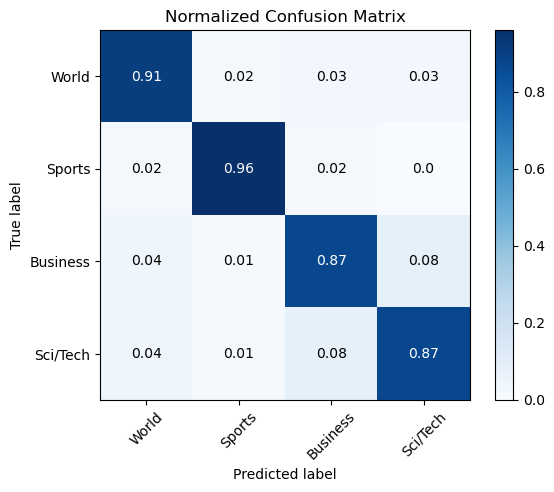

In [ ]:
#Evaluating the model

test_acc = accuracy(rnn_model, test_loader)

print(f'Test Accuracy: {test_acc:.4f}')

plot_confusion_matrix(rnn_model, test_loader)


In [ ]:
#Printing some random samples

print_random_sample_predictions(rnn_model, test_loader, num_samples=5)

Text: medtronic quarterly net up chicago ( reuters ) - medtronic inc . &lt a href=http //www . investor . reuters . com/fullquote . aspx ? ticker=mdt . n target=/stocks/quickinfo/fullquote&gt mdt . n&lt /a&gt on wednesday said its quarterly earnings rose on brisk demand for devices that manage irregular heart beats
True Label: Business, Predicted Label: Business

Text: oil companies in nigeria say they won #39 t give in to threats major oil companies operating in nigeria #39 s oil-rich southern region say they will not give in to threats of attacks on their facilities and employees by militias .
True Label: World, Predicted Label: Business

Text: champions league arsenal 1 , psv eindhoven 0 arsenal benefited from an own-goal in a 1-0 win over psv eindhoven in its opening champions league match at highbury on tuesday . the gunners largely dominated the group e match , with jose antonio
True Label: Sports, Predicted Label: Sports

Text: nortel to file restated results next year nortel ne

Conclusions:

- The model performs well in identifying major categories, especially "Sports," which has the fewest misclassifications.

- There is a tendency of misclassification between "World" and "Business" and between "Sci/Tech" and "Business", these categories could benefit from additional distinguishing features or more labeled data to capture subtle differences.

- Given that the model achieves high accuracy and handles clear distinctions well, it’s likely suitable for applications needing general topic classification. However, for high-stakes applications requiring precise categorization in areas with content overlap, further refinement might be needed.